# A one degree coupled Ocean - Sea Ice model

In [50]:
using Pkg
Pkg.activate("./")

using ClimaOcean, ClimaSeaIce
using Oceananigans, Oceananigans.Units
using CairoMakie, Printf, Statistics, Dates

  Activating project at `~/development/ClimaOcean.jl`


In [51]:
Nx = 360 # Longitudinal direction 
Ny = 180 # Meridional direction 
Nz = 60  # Vertical levels

r_faces = ExponentialCoordinate(Nz, -6000, 0)

grid = TripolarGrid(CPU(); size=(Nx, Ny, Nz), z=r_faces, halo=(5, 5, 4))

# Regridding the bathymetry...
bottom_height = regrid_bathymetry(grid; minimum_depth=15, major_basins=1, interpolation_passes=15)
grid = ImmersedBoundaryGrid(grid, GridFittedBottom(bottom_height); active_cells_map=true)

[ Info: Interpolation passes of bathymetry size (21600, 10800, 1) onto a TripolarGrid target grid of size (360, 180, 60):
[ Info:     pass 1 to size (20184, 10092, 1)
[ Info:     pass 2 to size (18768, 9384, 1)
[ Info:     pass 3 to size (17352, 8676, 1)
[ Info:     pass 4 to size (15936, 7968, 1)
[ Info:     pass 5 to size (14520, 7260, 1)
[ Info:     pass 6 to size (13104, 6552, 1)
[ Info:     pass 7 to size (11688, 5844, 1)
[ Info:     pass 8 to size (10272, 5136, 1)
[ Info:     pass 9 to size (8856, 4428, 1)
[ Info:     pass 10 to size (7440, 3720, 1)
[ Info:     pass 11 to size (6024, 3012, 1)
[ Info:     pass 12 to size (4608, 2304, 1)
[ Info:     pass 13 to size (3192, 1596, 1)
[ Info:     pass 14 to size (1776, 888, 1)
[ Info:     pass 15 to size (360, 180, 1)


360×180×60 ImmersedBoundaryGrid{Float64, Periodic, Oceananigans.Grids.RightConnected, Bounded} on CPU with 5×5×4 halo:
├── immersed_boundary: GridFittedBottom(mean(z)=-2261.31, min(z)=-6000.0, max(z)=0.0)
├── underlying_grid: 360×180×60 OrthogonalSphericalShellGrid{Float64, Periodic, Oceananigans.Grids.RightConnected, Bounded} on CPU with 5×5×4 halo and with precomputed metrics
├── centered at (λ, φ) = (70.0, 1.8005)
├── longitude: Periodic  extent 360.162 degrees                          variably spaced with min(Δλ)=0.00753834, max(Δλ)=1.05373
├── latitude:  Oceananigans.Grids.RightConnected  extent 170.944 degrees variably spaced with min(Δφ)=0.0113516, max(Δφ)=0.949721
└── z:         Bounded  z ∈ [-6000.0, 0.0]                               variably spaced with min(Δz)=3.53716, max(Δz)=482.988

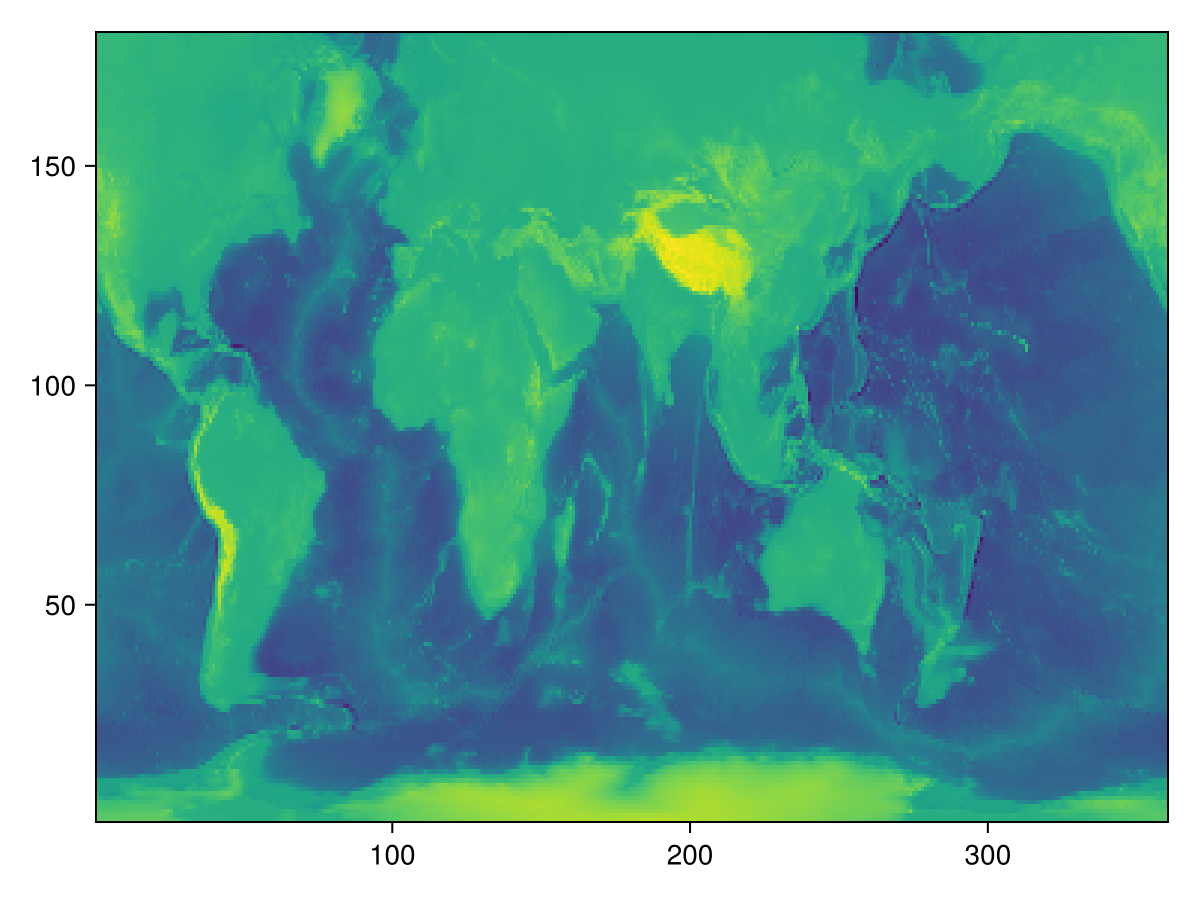

In [52]:
heatmap(interior(bottom_height, :, :, 1))

## A Prognostic Ocean model

In [53]:
# Advection
momentum_advection = WENOVectorInvariant(order=5)
tracer_advection   = WENO(order=5)

# Free Surface
free_surface = SplitExplicitFreeSurface(grid; substeps=70)

# Parameterizations
catke_closure = RiBasedVerticalDiffusivity()
eddy_closure  = Oceananigans.TurbulenceClosures.IsopycnalSkewSymmetricDiffusivity(κ_skew=1e3, κ_symmetric=1e3)
closures      = (catke_closure, eddy_closure, VerticalScalarDiffusivity(κ=1e-5, ν=1e-4))

# The ocean simulation
ocean = ocean_simulation(grid; 
                         momentum_advection,
                         tracer_advection,
                         free_surface,
                         timestepper = :SplitRungeKutta3,
                         closure = closures)

ocean.model

┌ Warning: RiBasedVerticalDiffusivity is an experimental turbulence closure that 
│ is unvalidated and whose default parameters are not calibrated for 
│ realistic ocean conditions or for use in a three-dimensional 
│ simulation. Use with caution and report bugs and problems with physics 
│ to https://github.com/CliMA/Oceananigans.jl/issues.
└ @ Oceananigans.TurbulenceClosures ~/.julia/packages/Oceananigans/Xjsq1/src/TurbulenceClosures/turbulence_closure_implementations/ri_based_vertical_diffusivity.jl:141
┌ Warning: Split barotropic-baroclinic time stepping with SplitRungeKutta3TimeStepper is and experimental.
│ Use at own risk, and report any issues encountered at [https://github.com/CliMA/Oceananigans.jl/issues](https://github.com/CliMA/Oceananigans.jl/issues).
└ @ Oceananigans.TimeSteppers ~/.julia/packages/Oceananigans/Xjsq1/src/TimeSteppers/split_hydrostatic_runge_kutta_3.jl:62


HydrostaticFreeSurfaceModel{CPU, ImmersedBoundaryGrid}(time = 0 seconds, iteration = 0)
├── grid: 360×180×60 ImmersedBoundaryGrid{Float64, Periodic, Oceananigans.Grids.RightConnected, Bounded} on CPU with 5×5×4 halo
├── timestepper: SplitRungeKutta3TimeStepper
├── tracers: (T, S)
├── closure: Tuple with 3 closures:
│   ├── RiBasedVerticalDiffusivity{VerticallyImplicitTimeDiscretization}
│   ├── IsopycnalSkewSymmetricDiffusivity(κ_skew=1000.0, κ_symmetric=1000.0)
│   └── VerticalScalarDiffusivity{ExplicitTimeDiscretization}(ν=0.0001, κ=(T=1.0e-5, S=1.0e-5))
├── buoyancy: SeawaterBuoyancy with g=9.80665 and BoussinesqEquationOfState{Float64} with ĝ = NegativeZDirection()
├── free surface: SplitExplicitFreeSurface with gravitational acceleration 9.80665 m s⁻²
│   └── substepping: FixedSubstepNumber(50)
├── advection scheme: 
│   ├── momentum: WENOVectorInvariant{3, Float64, Float32}(vorticity_order=5, vertical_order=5)
│   ├── T: WENO{3, Float64, Float32}(order=5)
│   └── S: WENO{3, Floa

## A Prognostic Sea Ice model

In [54]:
dynamics = ClimaOcean.SeaIceSimulations.sea_ice_dynamics(grid, ocean; solver=ClimaSeaIce.SeaIceDynamics.SplitExplicitSolver(substeps=70))
sea_ice = sea_ice_simulation(grid, ocean; dynamics, advection=WENO(order=7))

sea_ice.model

SeaIceModel{CPU, ImmersedBoundaryGrid}(time = 0 seconds, iteration = 0)
├── grid: 360×180×60 ImmersedBoundaryGrid{Float64, Periodic, Oceananigans.Grids.RightConnected, Bounded} on CPU with 5×5×4 halo
├── ice_thermodynamics: SlabThermodynamics
├── advection: WENO{4, Float64, Float32}(order=7)
└── external_heat_fluxes: 
    ├── top: 360×180×1 Field{Center, Center, Nothing} reduced over dims = (3,) on ImmersedBoundaryGrid on CPU
    └── bottom: 360×180×1 Field{Center, Center, Nothing} reduced over dims = (3,) on ImmersedBoundaryGrid on CPU

## Setting the initial conditions

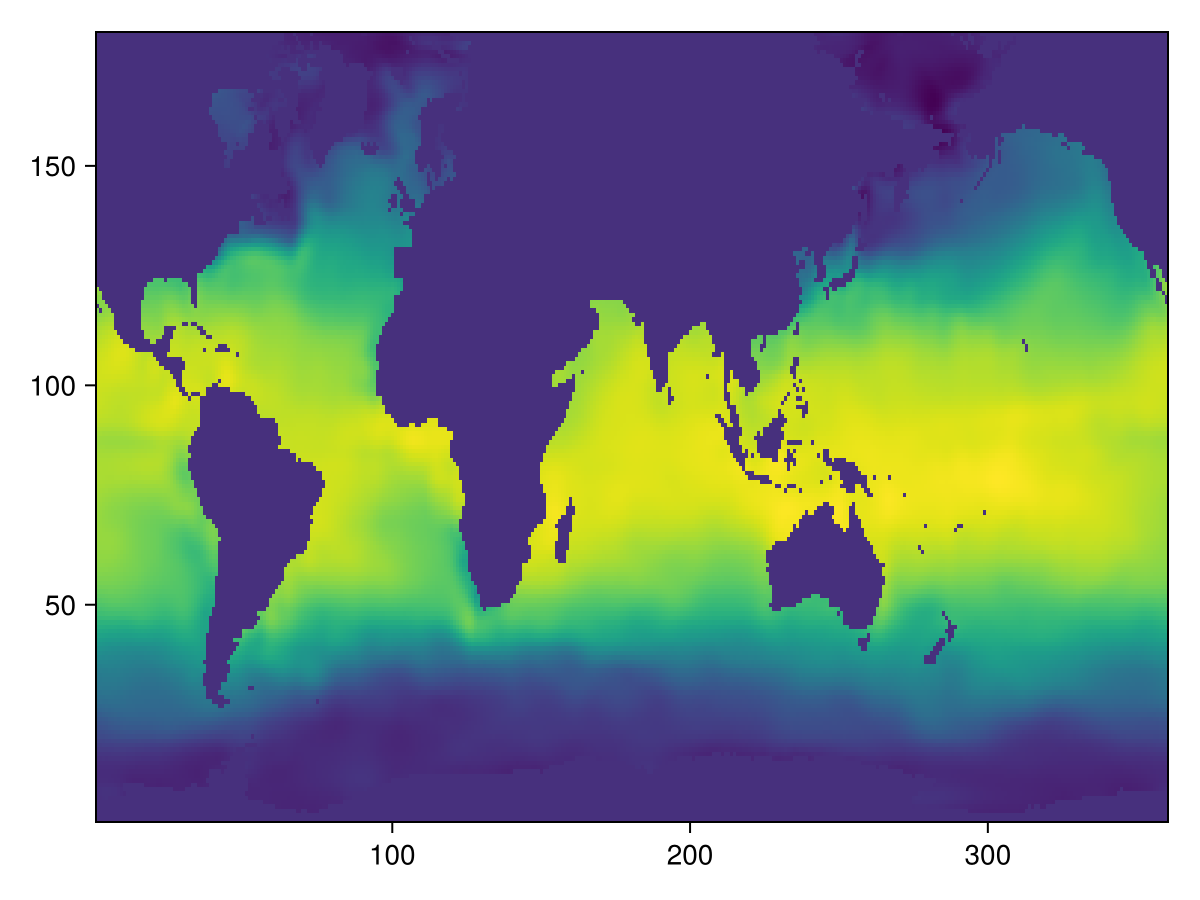

In [55]:
date = DateTime(1958, 1, 1)

set!(ocean.model, T=Metadatum(:temperature; dataset=EN4Monthly(), date),
                  S=Metadatum(:salinity;    dataset=EN4Monthly(), date))

set!(sea_ice.model, h=Metadatum(:sea_ice_thickness;     dataset=ECCO4Monthly()),
                    ℵ=Metadatum(:sea_ice_concentration; dataset=ECCO4Monthly()))

heatmap(interior(ocean.model.tracers.T, :, :, grid.Nz))

## A Prescribed Atmosphere (to be swapped with SpeedyWeather!)

In [56]:
dir = "./forcing_data"
backend = JRA55NetCDFBackend(100)

atmosphere = JRA55PrescribedAtmosphere(; backend, include_rivers_and_icebergs=true)
radiation  = Radiation(ocean_albedo = 0.06, sea_ice_albedo = 0.70)

┌ Warning: `end_date` (1990-12-31T21:00:00) is after the last date in the dataset 1990-12-31T00:00:00
└ @ ClimaOcean.DataWrangling ~/development/ClimaOcean.jl/src/DataWrangling/metadata.jl:275
┌ Warning: `end_date` (1990-12-31T21:00:00) is after the last date in the dataset 1990-12-31T00:00:00
└ @ ClimaOcean.DataWrangling ~/development/ClimaOcean.jl/src/DataWrangling/metadata.jl:275


Radiation{Float64}:
├── stefan_boltzmann_constant: 5.67e-8
├── emission: SurfaceProperties
│   ├── ocean: 0.97
│   └── sea_ice: 0.97
└── reflection: SurfaceProperties
    ├── ocean: 0.06
    └── sea_ice: 0.7

# The ESM in all his glory!

In [57]:
omip = OceanSeaIceModel(ocean, sea_ice; atmosphere, radiation)
omip = Simulation(omip, Δt=1hours, stop_time=20days) 
omip.model

OceanSeaIceModel{CPU}(time = 0 seconds, iteration = 0)
├── ocean: HydrostaticFreeSurfaceModel{CPU, ImmersedBoundaryGrid}(time = 0 seconds, iteration = 0)
├── atmosphere: 640×320×1×2920 PrescribedAtmosphere{Float32}
├── sea_ice: SeaIceModel
└── interfaces: ComponentInterfaces

### Output some progress (we do not want to run blind...)

In [ ]:
wall_time = Ref(time_ns())

function progress(sim)
    
    step_time = 1e-9 * (time_ns() - wall_time[])
    
    sea_ice = sim.model.sea_ice
    ocean   = sim.model.ocean
    hmax = maximum(sea_ice.model.ice_thickness)
    Tmax = maximum(sim.model.interfaces.atmosphere_sea_ice_interface.temperature)
    Tmin = minimum(sim.model.interfaces.atmosphere_sea_ice_interface.temperature)
    umax = maximum(ocean.model.velocities.u)
    vmax = maximum(ocean.model.velocities.v)
    wmax = maximum(ocean.model.velocities.w)

    msg1 = @sprintf("time: %s, ", prettytime(sim))
    msg2 = @sprintf("max(h): %.2f m, ", hmax)
    msg4 = @sprintf("ext(T): (%.2f, %.2f) ᵒC, ", Tmax, Tmin)
    msg5 = @sprintf("max(u): (%.2f, %.2f, %.2f) m/s, ", umax, vmax, wmax)
    msg6 = @sprintf("SYPD: %.3f \n", 1 / (step_time / (400 * 60) * 365))

    @info msg1 * msg2 * msg4 * msg5 * msg6

     wall_time[] = time_ns()

     return nothing
end

# And add it as a callback to the simulation.
add_callback!(omip, progress, IterationInterval(10))

# LET'S GOOOOOO!

In [ ]:
run!(omip)

[ Info: Initializing simulation...
[ Info: time: 0 seconds, max(h): 4.03 m, ext(T): (30.20, -34.19) ᵒC, max(u): (0.00, 0.00, 0.00) m/s, SYPD: 17.489 
[ Info:     ... simulation initialization complete (1.109 seconds)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (3.611 seconds).
[ Info: time: 10 hours, max(h): 4.99 m, ext(T): (30.32, -34.49) ᵒC, max(u): (0.68, 0.84, 0.02) m/s, SYPD: 5.819 
[ Info: time: 20 hours, max(h): 5.58 m, ext(T): (30.15, -35.37) ᵒC, max(u): (0.78, 0.92, 0.02) m/s, SYPD: 6.544 
[ Info: time: 1.250 days, max(h): 5.74 m, ext(T): (30.53, -33.33) ᵒC, max(u): (0.79, 1.04, 0.01) m/s, SYPD: 6.616 
[ Info: time: 1.667 days, max(h): 5.72 m, ext(T): (30.31, -34.90) ᵒC, max(u): (0.76, 0.97, 0.01) m/s, SYPD: 6.632 


In [ ]:
heatmap(interior(ocean.model.tracers.T, :, :, grid.Nz))

In [ ]:
heatmap(interior(sea_ice.model.ice_thickness, :, :, 1), colorrange=(0, 4), colormap=:ice)